# 1.このSprintについて

Sprintの目的
- スクラッチを通してロジスティック回帰を理解する
- 分類問題についての基礎を学ぶ

どのように学ぶか
- スクラッチでロジスティック回帰を実装した後、学習と検証を行なっていきます。

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# 【問題1】仮定関数
ロジスティック回帰の仮定関数のメソッドをScratchLogisticRegressionクラスに実装してください。


ロジスティック回帰の仮定関数は、線形回帰の仮定関数を シグモイド関数 に通したものです。シグモイド関数は以下の式で表されます。

$$
g(z) = \frac{1}{1+e^{−z}}
$$

線形回帰の仮定関数は次の式でした。

$$
h_\theta(x) = \theta^T \cdot x
$$

まとめて書くと、ロジスティック回帰の仮定関数は次のようになります。

$$
h_\theta(x) = \frac{1}{1+e^{−\theta^T \cdot x}}
$$
$x$ : 特徴量ベクトル  
$\theta$ : パラメータ（重み）ベクトル

# 【問題2】最急降下法
最急降下法により学習させる実装を行なってください。以下の式で表されるパラメータの更新式のメソッド_gradient_descentを追加し、fit
メソッドから呼び出すようにしてください。

$$
\theta_j := \theta_j - \alpha \frac{\partial J(\theta)}{\partial \theta_j}\\<br/>\frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m}  \sum_{i=1}^{m}(h_θ(x^{(i)}) − y^{(i)})x_j^{(i)}  ,j = 0\\<br/>\frac{\partial J(\theta)}{\partial \theta_j} = \biggl(\frac{1}{m}  \sum_{i=1}^{m}(h_θ(x^{(i)}) − y^{(i)})x_j^{(i)} \biggr) + \frac{λ}{m}\theta_j　 ,j\geq 1
$$

$\alpha$ : 学習率  
$i$ : サンプルのインデックス  
$j$ : 特徴量のインデックス  
$m$ : 入力されるデータの数  
$h_\theta()$ : 仮定関数  
$x$ : 特徴量ベクトル  
$\theta$ : パラメータ（重み）ベクトル  
$x^{(i)}$ : i番目のサンプルの特徴量ベクトル  
$y^{(i)}$ : i番目のサンプルの正解ラベル  
$\theta_j$ : j番目のパラメータ（重み）  
$λ$ : 正則化パラメータ  

# 【問題3】推定
推定する仕組みを実装してください。ScratchLogisticRegressionクラスの雛形に含まれるpredictメソッドとpredict_probaメソッドに書き加えてください。


仮定関数 $h_\theta(x)$ の出力がpredict_probaの返り値、さらにその値に閾値を設けて1と0のラベルとしたものがpredictの返り値となります。

# 【問題4】目的関数
以下の数式で表されるロジスティック回帰の 目的関数（損失関数） を実装してください。そして、これをself.loss, self.val_lossに記録するようにしてください。なお、この数式には正則化項が含まれています。

$$
J(\theta)=  \frac{1}{m}  \sum_{i=1}^{m}[−y^{(i)} log(h_θ(x^{(i)})) − (1−y^{(i)}) log(1−h_θ(x^{(i)}))] +
\frac{λ}{2m}\sum_{j=1}^n
θ^2_j
$$

$m$ : 入力されるデータの数  
$h_\theta()$ : 仮定関数  
$x$ : 特徴量ベクトル  
$\theta$ : パラメータ（重み）ベクトル  
$x^{(i)}$ : i番目のサンプルの特徴量ベクトル  
$y^{(i)}$ : i番目のサンプルの正解ラベル  
$\theta_j$ : j番目のパラメータ（重み）  
$n$ : 特徴量の数  
$λ$ : 正則化パラメータ  

In [2]:
class ScratchLogisticRegression():
    """
    ロジスティック回帰のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    no_bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      訓練データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証データに対する損失の記録

    """
    def __init__(self, num_iter, lr, C, no_bias, verbose):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.C = C
        self.no_bias = no_bias
        self.verbose = verbose
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ロジスティック回帰を学習する。検証データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        # バイアスの有無
        if not self.no_bias:
            X = np.insert(X, 0, 1, axis=1)
            if X_val is not None:
                X_val = np.insert(X_val, 0, 1, axis=1)
                
        # 係数の初期値を標準正規分布に従った乱数で生成
        self.coef_ = np.random.normal(loc=0, # 平均
                                      scale=0.01, # 標準偏差
                                      size=X.shape[1]).reshape(-1, 1)
        
        # イテレーション数回行う処理
        for i in range(self.iter):
            # 係数の更新
            self.coef_ = self._gradient_descent(X, y)
            # 目的関数
            self.loss[i] = self._logloss(self._sigmoid_function(X), y)      
            if X_val is not None:
                self.val_loss[i] = self._logloss(self._sigmoid_function(X_val), y_val)
            #verboseをTrueにした際は学習過程を出力    
            if self.verbose:
                print(f'train_loss：{self.loss[i]}')
                if X_val is not None:
                    print(f'val_loss：{self.val_loss[i]}')

    def _sigmoid_function(self, X):
        """
        仮定関数を計算する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          訓練データ

        Returns
        -------
          次の形のndarray, shape (n_samples, 1)
          線形の仮定関数による推定結果

        """
        return 1 / (1 + np.exp(-1 * X @ self.coef_))

    def _gradient_descent(self, X, y):
        """
        最急降下法により学習させる
        """
        _theta = self.coef_[0] - np.mean(self._sigmoid_function(X) - y)
        self.coef_ -= self.lr * ((1 / len(X)) * X.T @ (self._sigmoid_function(X) - y) + (1 / (self.C *len(X))) * self.coef_)
        if not self.no_bias:
            self.coef_[0] = _theta
            
        return self.coef_
    
    def predict(self, X):
        """
        ロジスティック回帰を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        if not self.no_bias:
            X = np.insert(X, 0, 1, axis=1)

        return np.where(self._sigmoid_function(X) < 0.5, 0, 1).ravel()
    
    def predict_proba(self, X):
        """
        ロジスティック回帰を使い確率を推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        if not self.no_bias:
            X = np.insert(X, 0, 1, axis=1)
            
        return self._sigmoid_function(X)
    
    def _logloss(self, y_pred, y):
        pos = y.T @ np.log(y_pred)
        neg = (1 - y).T @ np.log(1 - y_pred)
        reg = self.coef_.T @ self.coef_
        
        return (- pos - neg + reg / self.C / 2) / len(y)

# 【問題5】学習と推定
機械学習スクラッチ入門のSprintで用意したirisデータセットのvirgicolorとvirginicaの2値分類に対してスクラッチ実装の学習と推定を行なってください。


scikit-learnによる実装と比べ、正しく動いているかを確認してください。


AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

## ・データ読み込み

In [3]:
# アイリスデータ
from sklearn.datasets import load_iris

# インスタンスを生成
data = load_iris()

# データをDataFrame型でXに格納する。
X = pd.DataFrame(data.data, columns=['sepal_length',
                                     'sepal_width',
                                     'petal_length',
                                     'petal_width'])
# 目的変数も同様にyに格納する。
y = pd.DataFrame(data.target, columns=['Species'])

# X,yを結合
df = pd.concat([X, y], axis=1) # axis=1 列方向に結合

# 2値分類としたいため、以下の2つの目的変数のみ利用します。特徴量は4種類全て使います。virgicolorとvirginica
df = df[df['Species']!=0]
df['Species'] -= 1 # ({0: virgicolor, 1: virginica})
df = df.reset_index(drop=True)

# 訓練データと検証データに分割
X = df.iloc[:, :-1].values
y = df[['Species']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

# 標準化
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

## ・スクラッチによる推定

In [4]:
# 学習
slr = ScratchLogisticRegression(num_iter=1000, lr=0.1, C=5, no_bias=False, verbose=False)
slr.fit(X_train_std, y_train, X_test_std, y_test)

# 推定
slr_pred = slr.predict(X_test_std)

## ・sklearnによる推定

In [5]:
from sklearn.linear_model import SGDClassifier

# 学習
sgdc = SGDClassifier(loss='log', random_state=0)
sgdc.fit(X_train_std, y_train)

# 推定
sgdc_pred = sgdc.predict(X_test_std)

## ・評価

In [6]:
scratch_eval = []
sklearn_eval = []

# Accuracy（正解率）
from sklearn.metrics import accuracy_score
scratch_eval.append(accuracy_score(y_test, slr_pred))
sklearn_eval.append(accuracy_score(y_test, sgdc_pred))

# Precision（適合率）
from sklearn.metrics import precision_score
scratch_eval.append(precision_score(y_test, slr_pred))
sklearn_eval.append(precision_score(y_test, sgdc_pred))

# Recall（再現率）
from sklearn.metrics import recall_score
scratch_eval.append(recall_score(y_test, slr_pred))
sklearn_eval.append(recall_score(y_test, sgdc_pred))

# F値
from sklearn.metrics import f1_score
scratch_eval.append(f1_score(y_test, slr_pred))
sklearn_eval.append(f1_score(y_test, sgdc_pred))

# 混合行列
from sklearn.metrics import confusion_matrix
print('-----------混合行列--------------------')
print('scratch')
print(confusion_matrix(y_test, slr_pred), )
print('--------')
print('sklearn')
print(confusion_matrix(y_test, sgdc_pred))
print('')
print('-----------predict--------------------')
print(f'scratch：{slr_pred}')
print(f'sklearn：{sgdc_pred}')
print(f'y_test ：{y_test.ravel()}')
print('')
print('-----------評価値----------------------')
display(pd.DataFrame([scratch_eval, sklearn_eval], columns=('Accuracy', 'Precision', 'Recall', 'F値'), index=('スクラッチ', 'sklearn')).T)

-----------混合行列--------------------
scratch
[[12  0]
 [ 0 13]]
--------
sklearn
[[12  0]
 [ 1 12]]

-----------predict--------------------
scratch：[1 0 1 1 1 0 1 1 1 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0 1]
sklearn：[1 0 1 1 1 0 1 1 1 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 1]
y_test ：[1 0 1 1 1 0 1 1 1 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0 1]

-----------評価値----------------------


,スクラッチ,sklearn
Accuracy,1.0,0.960000
Precision,1.0,1.000000
Recall,1.0,0.923077
F値,1.0,0.960000


# 【問題6】学習曲線のプロット
学習曲線を見て損失が適切に下がっているかどうか確認してください。

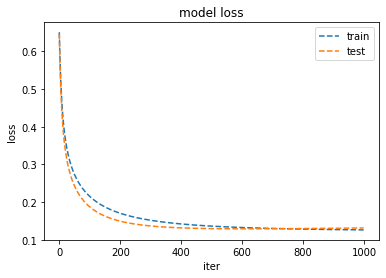

In [7]:
plt.title('model loss')
plt.xlabel('iter')
plt.ylabel('loss')
plt.plot(slr.loss, label=('train'), linestyle='--')
plt.plot(slr.val_loss, label=('test'), linestyle='--')
plt.legend();

# 【問題7】決定領域の可視化
決定領域を可視化してください。

## ・sepal_lengthとpetal_lengthで描画する。

In [8]:
# アイリスデータ
from sklearn.datasets import load_iris

# インスタンスを生成
data = load_iris()

# データをDataFrame型でXに格納する。
X = pd.DataFrame(data.data, columns=['sepal_length',
                                     'sepal_width',
                                     'petal_length',
                                     'petal_width'])
# 目的変数も同様にyに格納する。
y = pd.DataFrame(data.target, columns=['Species'])

# X,yを結合
df = pd.concat([X, y], axis=1) # axis=1 列方向に結合

# 2値分類としたいため、以下の2つの目的変数のみ利用します。特徴量は4種類全て使います。virgicolorとvirginica
df = df[df['Species']!=0]
df['Species'] -= 1 # ({0: virgicolor, 1: virginica})
df = df.reset_index(drop=True)

# 訓練データと検証データに分割
X = df[['sepal_length', 'petal_length']].values
y = df[['Species']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

# 標準化
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [9]:
# 学習
slr = ScratchLogisticRegression(num_iter=1000, lr=0.1, C=5, no_bias=False, verbose=False)
slr.fit(X_train_std, y_train, X_test_std, y_test)

# 推定
slr_pred = slr.predict(X_test_std)

In [10]:
from sklearn.linear_model import SGDClassifier

# 学習
sgdc = SGDClassifier(loss='log', random_state=0)
sgdc.fit(X_train_std, y_train)

# 推定
sgdc_pred = sgdc.predict(X_test_std)

In [11]:
# 決定領域の描画関数
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

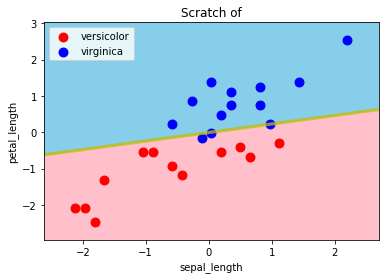

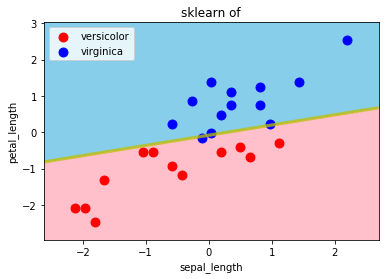

In [12]:
decision_region(X_test_std, y_test[:, 0], slr, step=0.01, title='Scratch of', xlabel='sepal_length', ylabel='petal_length', target_names=['versicolor', 'virginica'])
decision_region(X_test_std, y_test[:, 0], sgdc, step=0.01, title='sklearn of', xlabel='sepal_length', ylabel='petal_length', target_names=['versicolor', 'virginica'])

# 【問題8】（アドバンス課題）重みの保存
検証が容易になるように、学習した重みを保存および読み込みができるようにしましょう。pickleモジュールやNumPyのnp.savezを利用します。

In [13]:
slr.coef_

array([[ 0.02072493],
       [-1.02140986],
       [ 4.35508801]])

In [14]:
w1 = slr.coef_
np.savez('np_savez.npz', w1)
w2 = np.load('np_savez.npz')
w2.files

['arr_0']

In [15]:
w2['arr_0']

array([[ 0.02072493],
       [-1.02140986],
       [ 4.35508801]])

In [16]:
w2[w2.files[0]]

array([[ 0.02072493],
       [-1.02140986],
       [ 4.35508801]])